In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

fashion_df = pd.read_csv("data/fashion.csv")
fashion_df

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


In [10]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


In [11]:
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

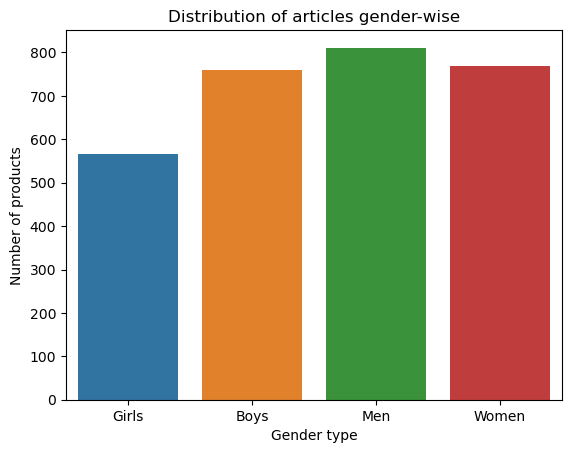

In [12]:
# Convert the "Gender" column to a categorical data type
#fashion_df["Gender"] = fashion_df["Gender"].astype("category")
plot = sns.countplot(data=fashion_df, x="Gender")
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())
plt.show()

In [13]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

In [6]:
# 3. Feature extraction using ResNet
# For Gender - Men
img_width, img_height = 224, 224

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "data/Footwear/Men/Images/"

nb_train_samples = 811
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((811, 100352))
    
    np.save(open('Men_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('Men_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 811 images belonging to 1 classes.


C:\Users\kakad\AppData\Local\Temp\ipykernel_11584\174756687.py:24: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:02:45.533923


In [7]:
footwear_men

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
1326,9204,Men,Footwear,Shoes,Casual Shoes,Black,Casual,Puma Men Future Cat Remix SF Black Casual Shoes,9204.jpg,http://assets.myntassets.com/v1/images/style/p...
1327,18653,Men,Footwear,Flip Flops,Flip Flops,Black,Casual,Fila Men Cush Flex Black Slippers,18653.jpg,http://assets.myntassets.com/v1/images/style/p...
1328,12967,Men,Footwear,Sandal,Sandals,Black,Casual,ADIDAS Men Spry M Black Sandals,12967.jpg,http://assets.myntassets.com/v1/images/style/p...
1329,9036,Men,Footwear,Shoes,Formal Shoes,Black,Formal,Buckaroo Men Flores Black Formal Shoes,9036.jpg,http://assets.myntassets.com/v1/images/style/p...
1330,39988,Men,Footwear,Shoes,Casual Shoes,White,Casual,Gas Men Europa White Shoes,39988.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2132,13359,Men,Footwear,Shoes,Casual Shoes,Beige,Casual,Timberland Men Juniors Beige Casual Shoes,13359.jpg,http://assets.myntassets.com/v1/images/style/p...
2133,11856,Men,Footwear,Flip Flops,Flip Flops,Red,Casual,Playboy Men Casual Red Slippers,11856.jpg,http://assets.myntassets.com/v1/images/style/p...
2134,22846,Men,Footwear,Shoes,Casual Shoes,Khaki,Casual,Woodland Men Khaki Casual Shoes,22846.jpg,http://assets.myntassets.com/v1/images/style/p...
2135,43871,Men,Footwear,Shoes,Casual Shoes,White,Casual,Puma Men White Driving Power Lo Shoes,43871.jpg,http://assets.myntassets.com/v1/images/style/p...


In [27]:
# 4. Computing the Euclidean distance and recommending similar products
# 4.1 Loading the extracted features
extracted_features = np.load('Men_ResNet_features.npy')
Productids = np.load('Men_ResNet_feature_product_ids.npy')
men = footwear_men.copy()
#men = pd.read_csv('./footwear_men.csv')
df_Productids = list(men['ProductId'])
Productids = list(Productids)

==================== input product image ====================


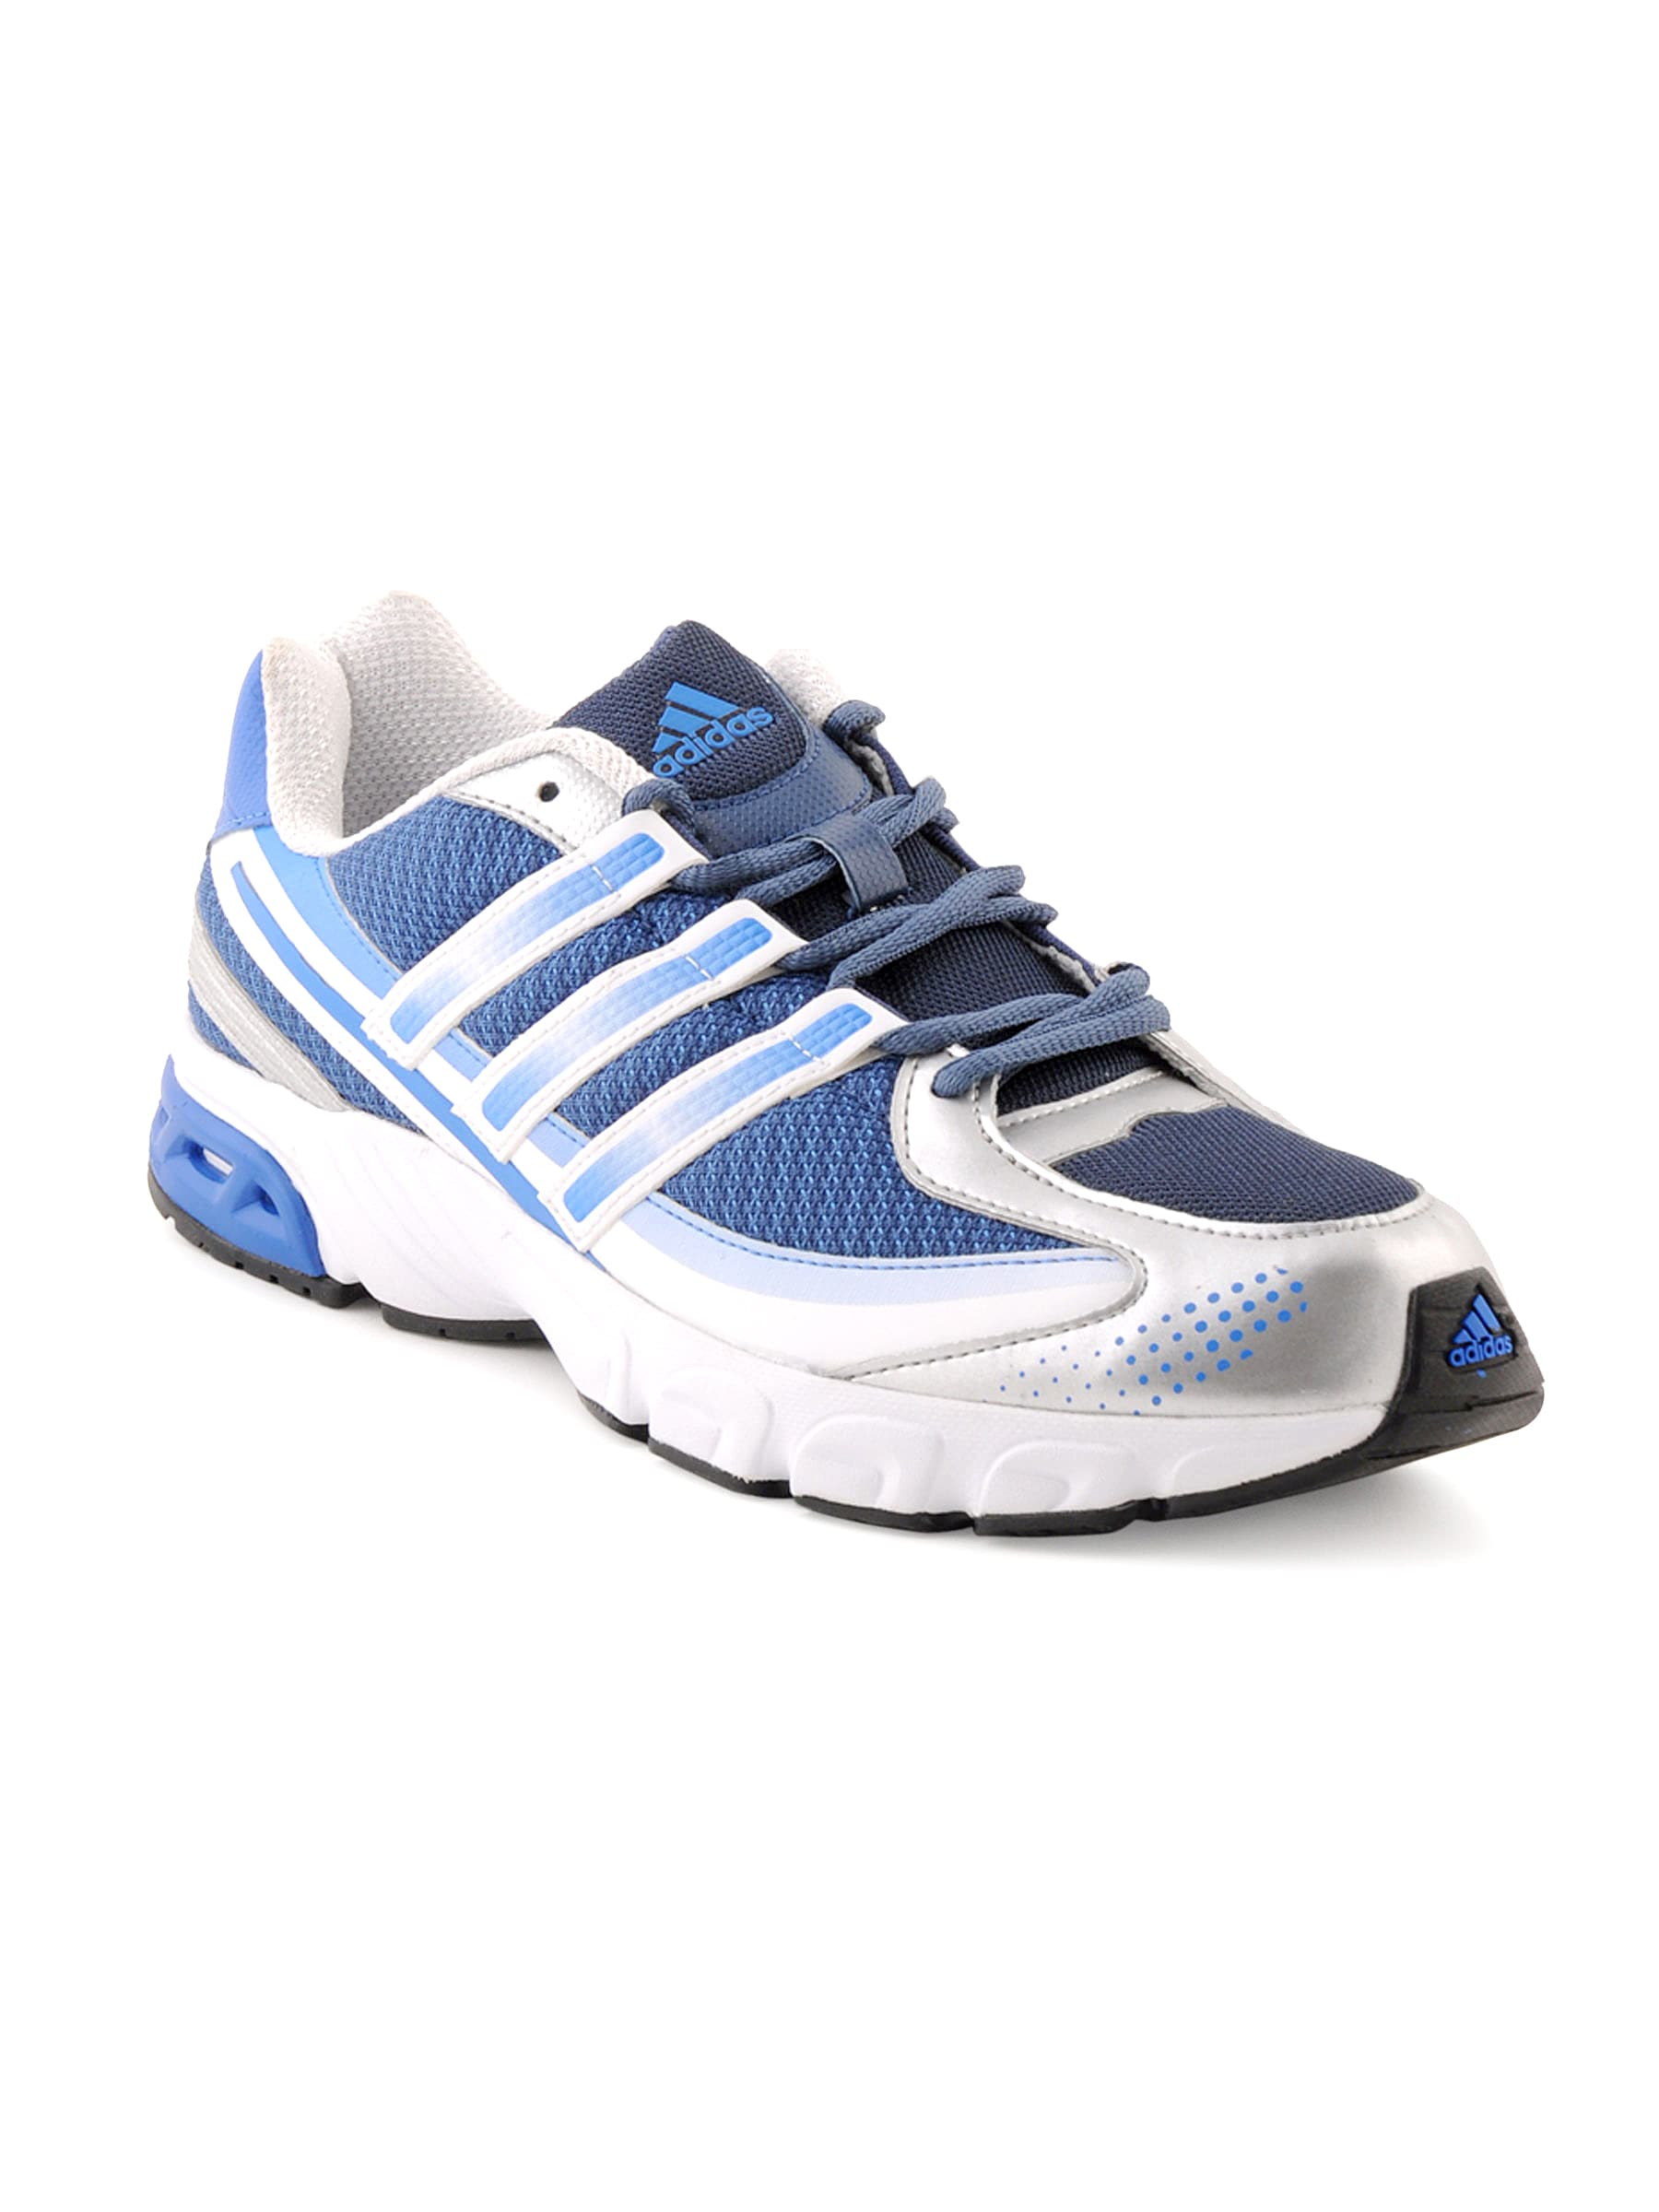

Product Title:  ADIDAS Men Adi Quest Blue Sports Shoes

 ==================== Recommended products ====================


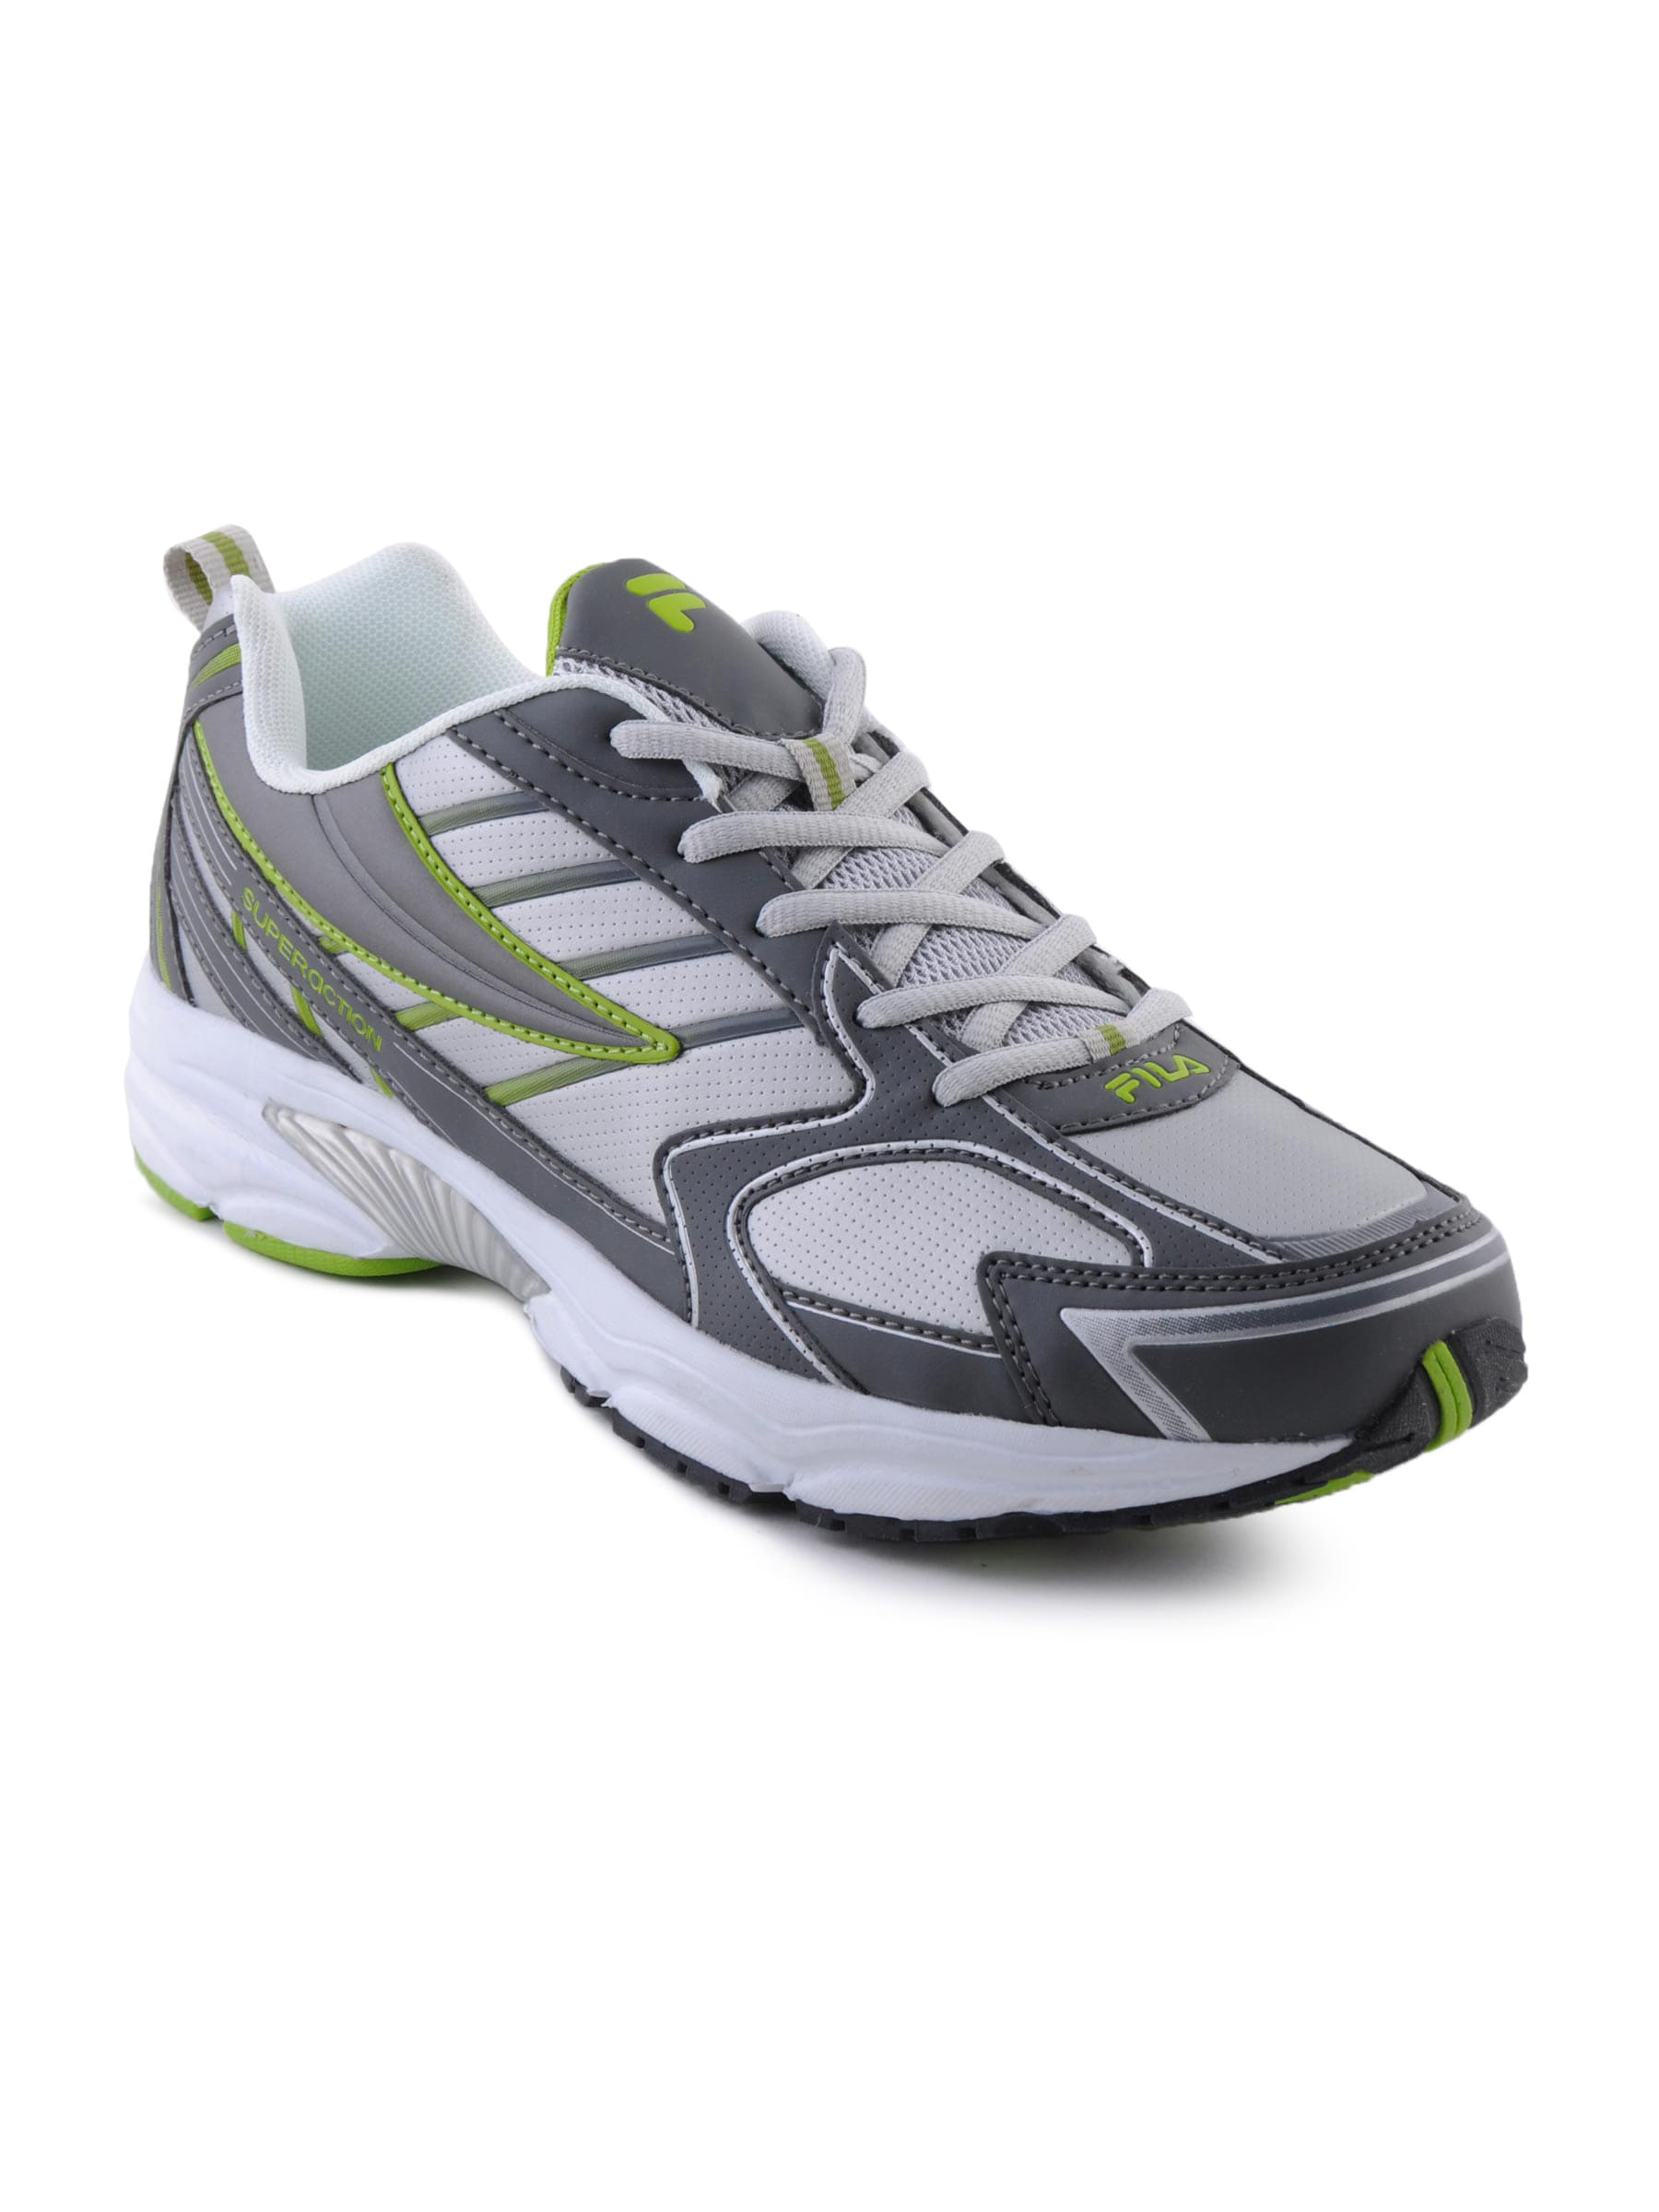

Product Title:  Fila Men Destiny Grey Sports Shoes
Euclidean Distance from input image: 27.668856


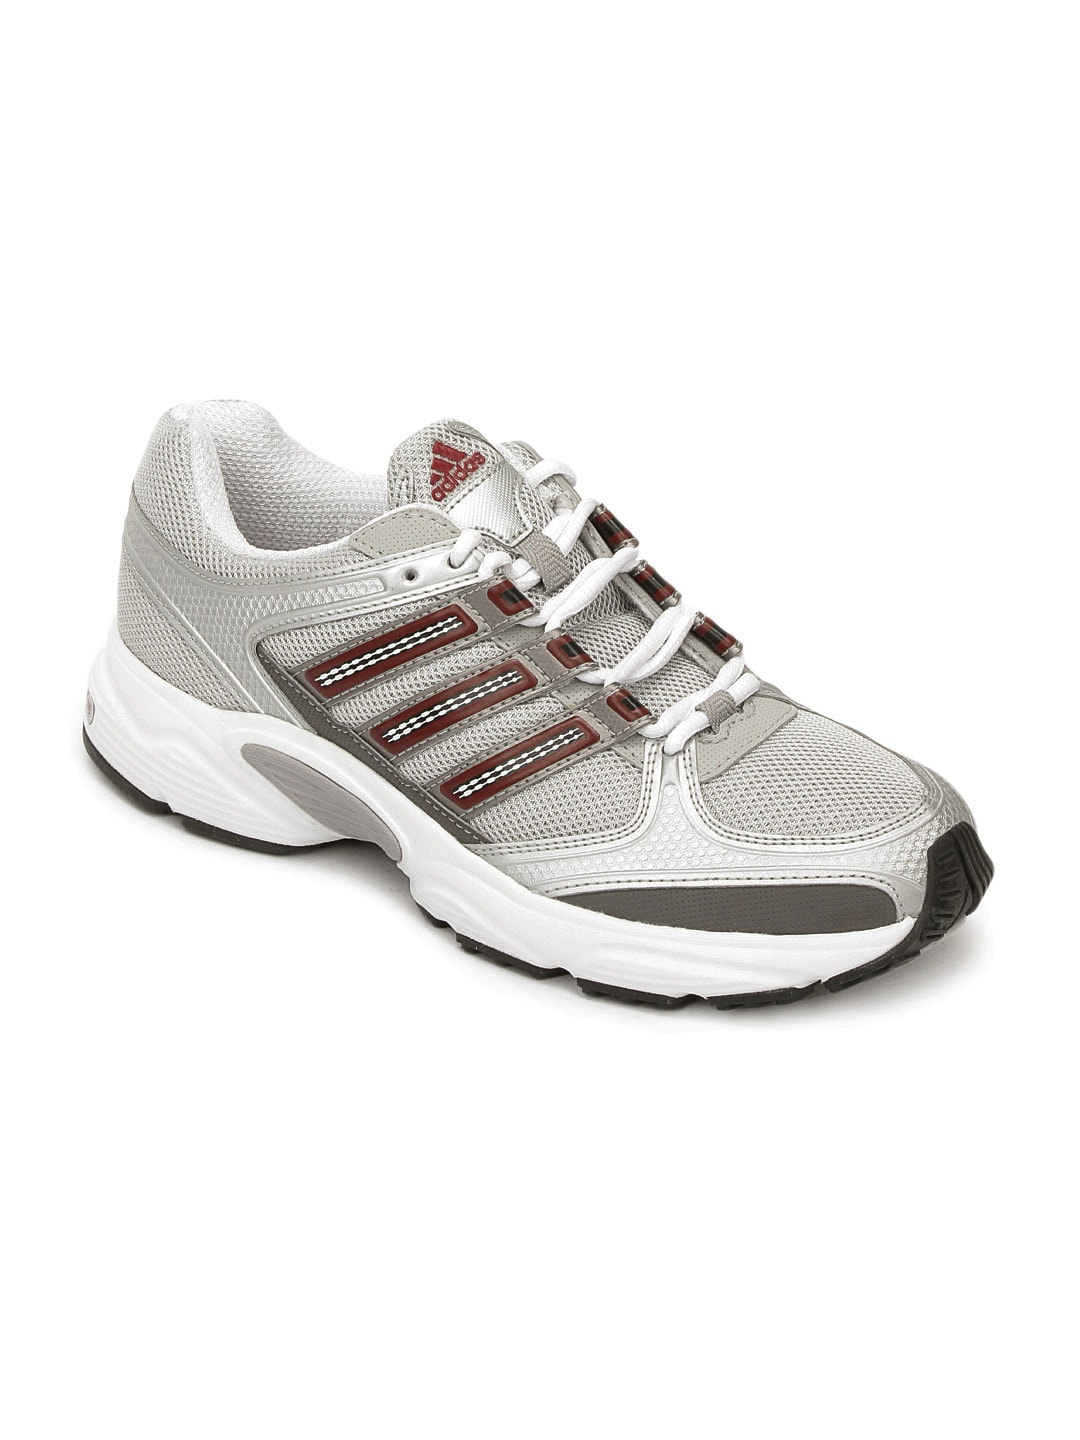

Product Title:  ADIDAS Men Silver Phaedra Shoes
Euclidean Distance from input image: 29.393417


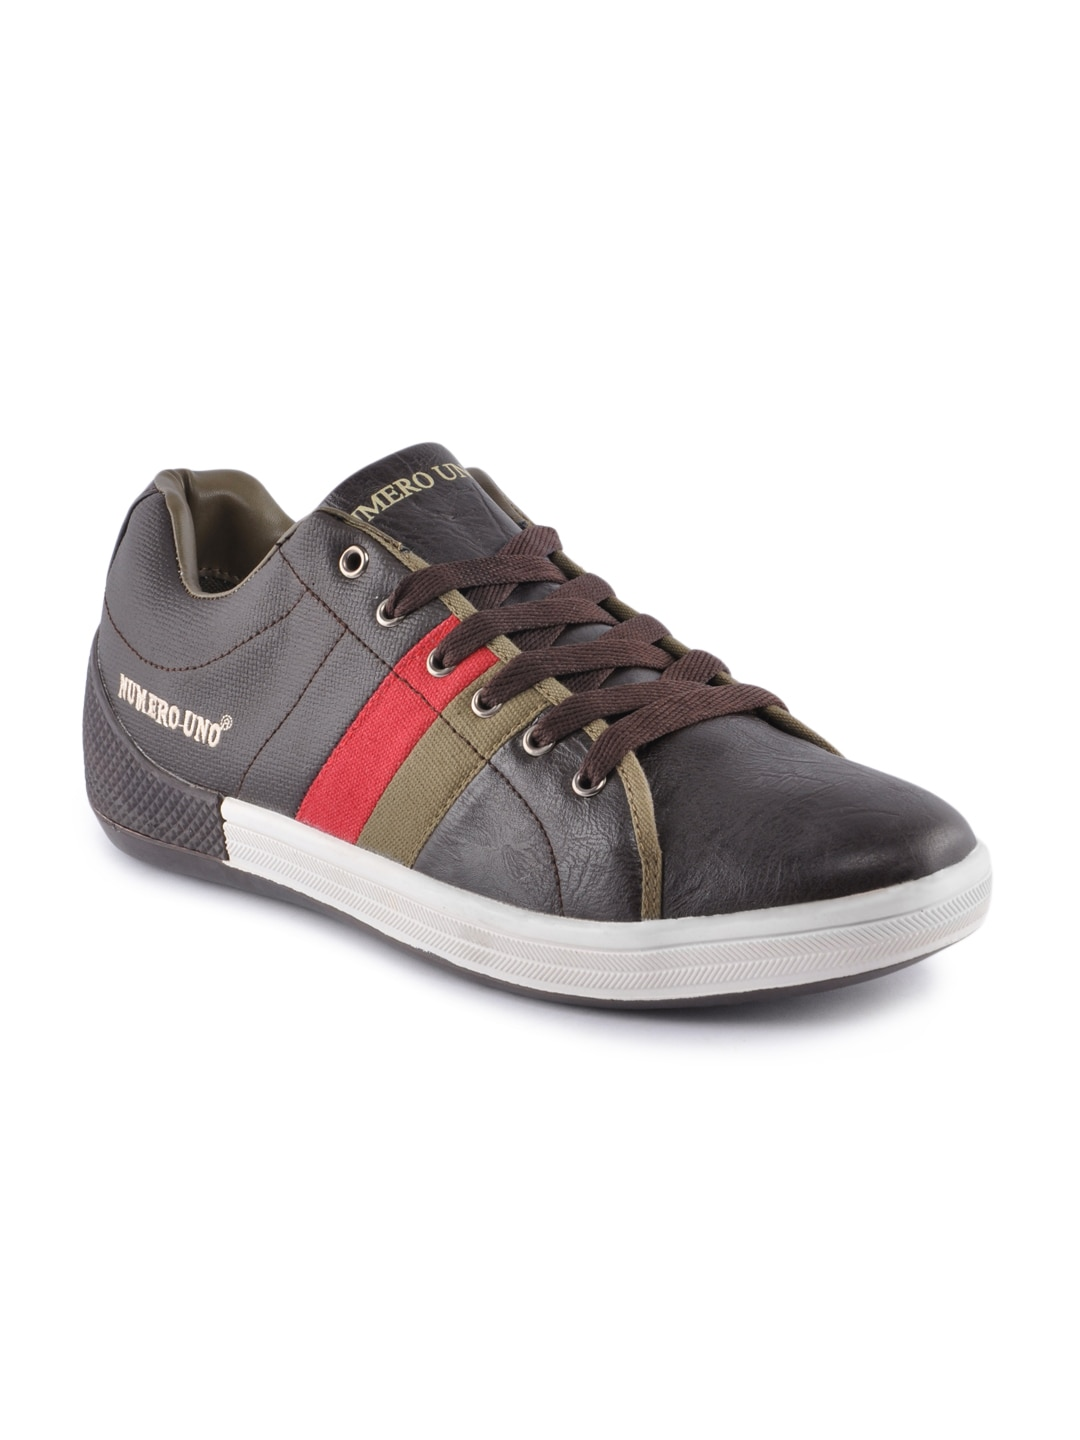

Product Title:  Numero Uno Men Brown Casual Shoes
Euclidean Distance from input image: 30.16472


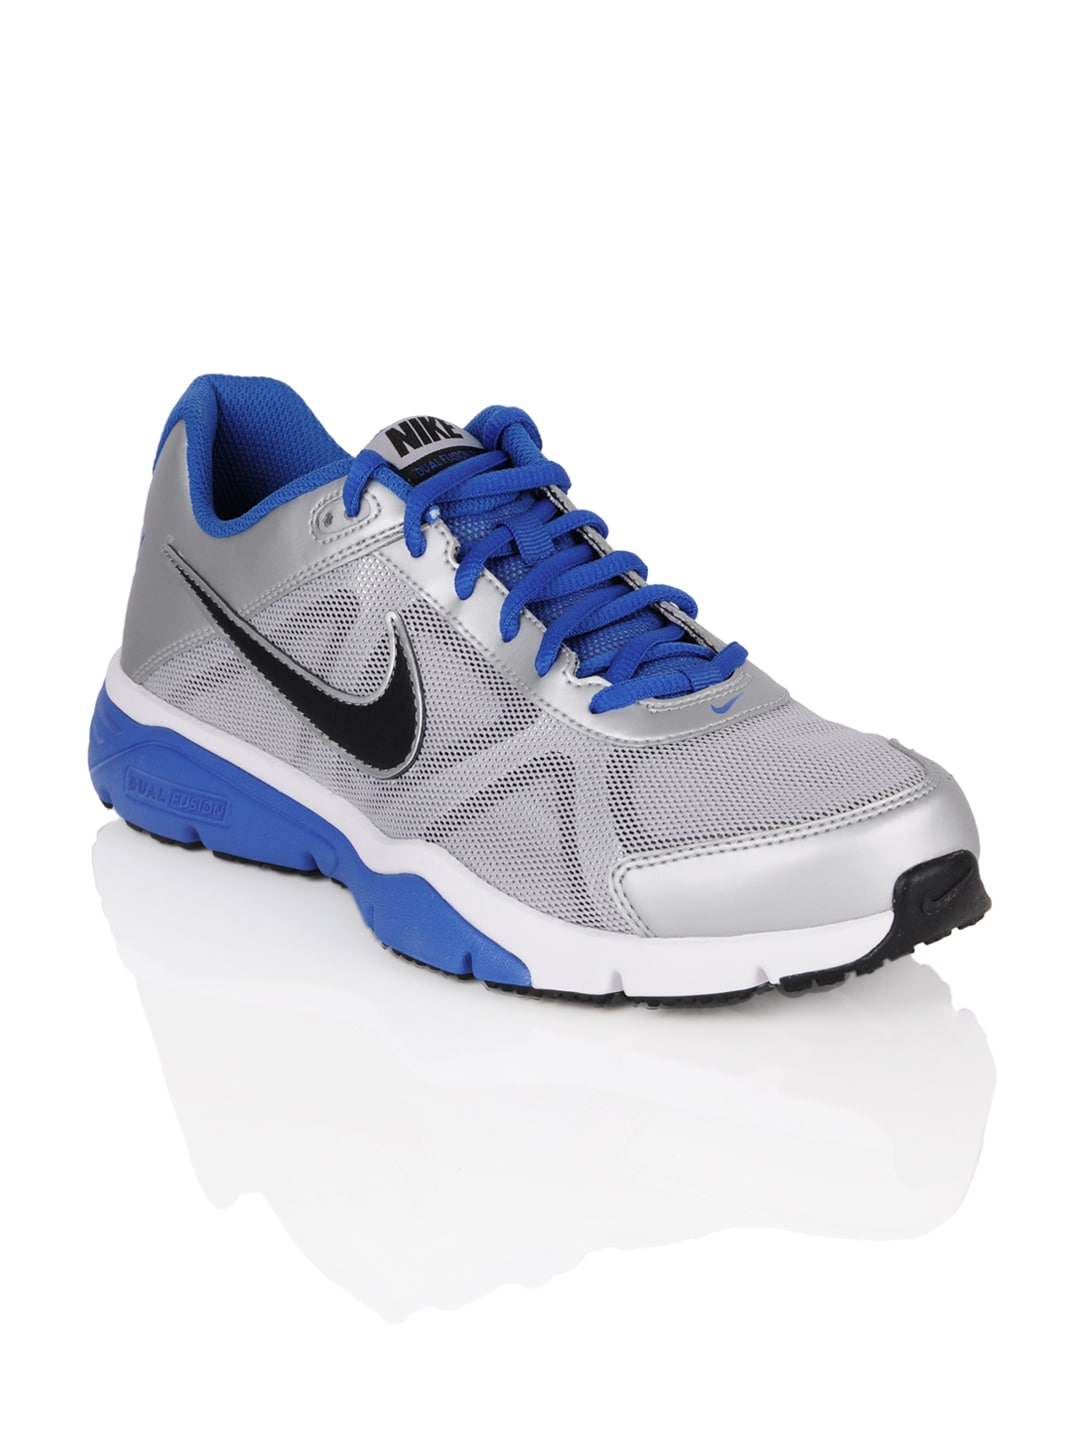

Product Title:  Nike Men Dual Fusion TR III Grey Sports Shoes
Euclidean Distance from input image: 30.953018


In [31]:
def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[0]])]
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('13683', 5)

In [32]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "data/Footwear/Women/Images/"

nb_train_samples = 769
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((769, 100352))
    
    np.save(open('./Women_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Women_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 769 images belonging to 1 classes.


C:\Users\kakad\AppData\Local\Temp\ipykernel_11584\52329193.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:02:35.348553


In [14]:
boys_extracted_features = np.load('./Boys_ResNet_features.npy')
boys_Productids = np.load('./Boys_ResNet_feature_product_ids.npy')
girls_extracted_features = np.load('./Girls_ResNet_features.npy')
girls_Productids = np.load('./Girls_ResNet_feature_product_ids.npy')
men_extracted_features = np.load('./Men_ResNet_features.npy')
men_Productids = np.load('./Men_ResNet_feature_product_ids.npy')
women_extracted_features = np.load('./Women_ResNet_features.npy')
women_Productids = np.load('./Women_ResNet_feature_product_ids.npy')
fashion_df["ProductId"] = fashion_df["ProductId"].astype(str)

In [15]:
def get_similar_products_cnn(product_id, num_results):
    if(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Boys"):
        extracted_features = boys_extracted_features
        Productids = boys_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Girls"):
        extracted_features = girls_extracted_features
        Productids = girls_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Men"):
        extracted_features = men_extracted_features
        Productids = men_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Women"):
        extracted_features = women_extracted_features
        Productids = women_Productids
    Productids = list(Productids)
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product details", "="*20)
    ip_row = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[0]]]
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

==================== input product details ====================


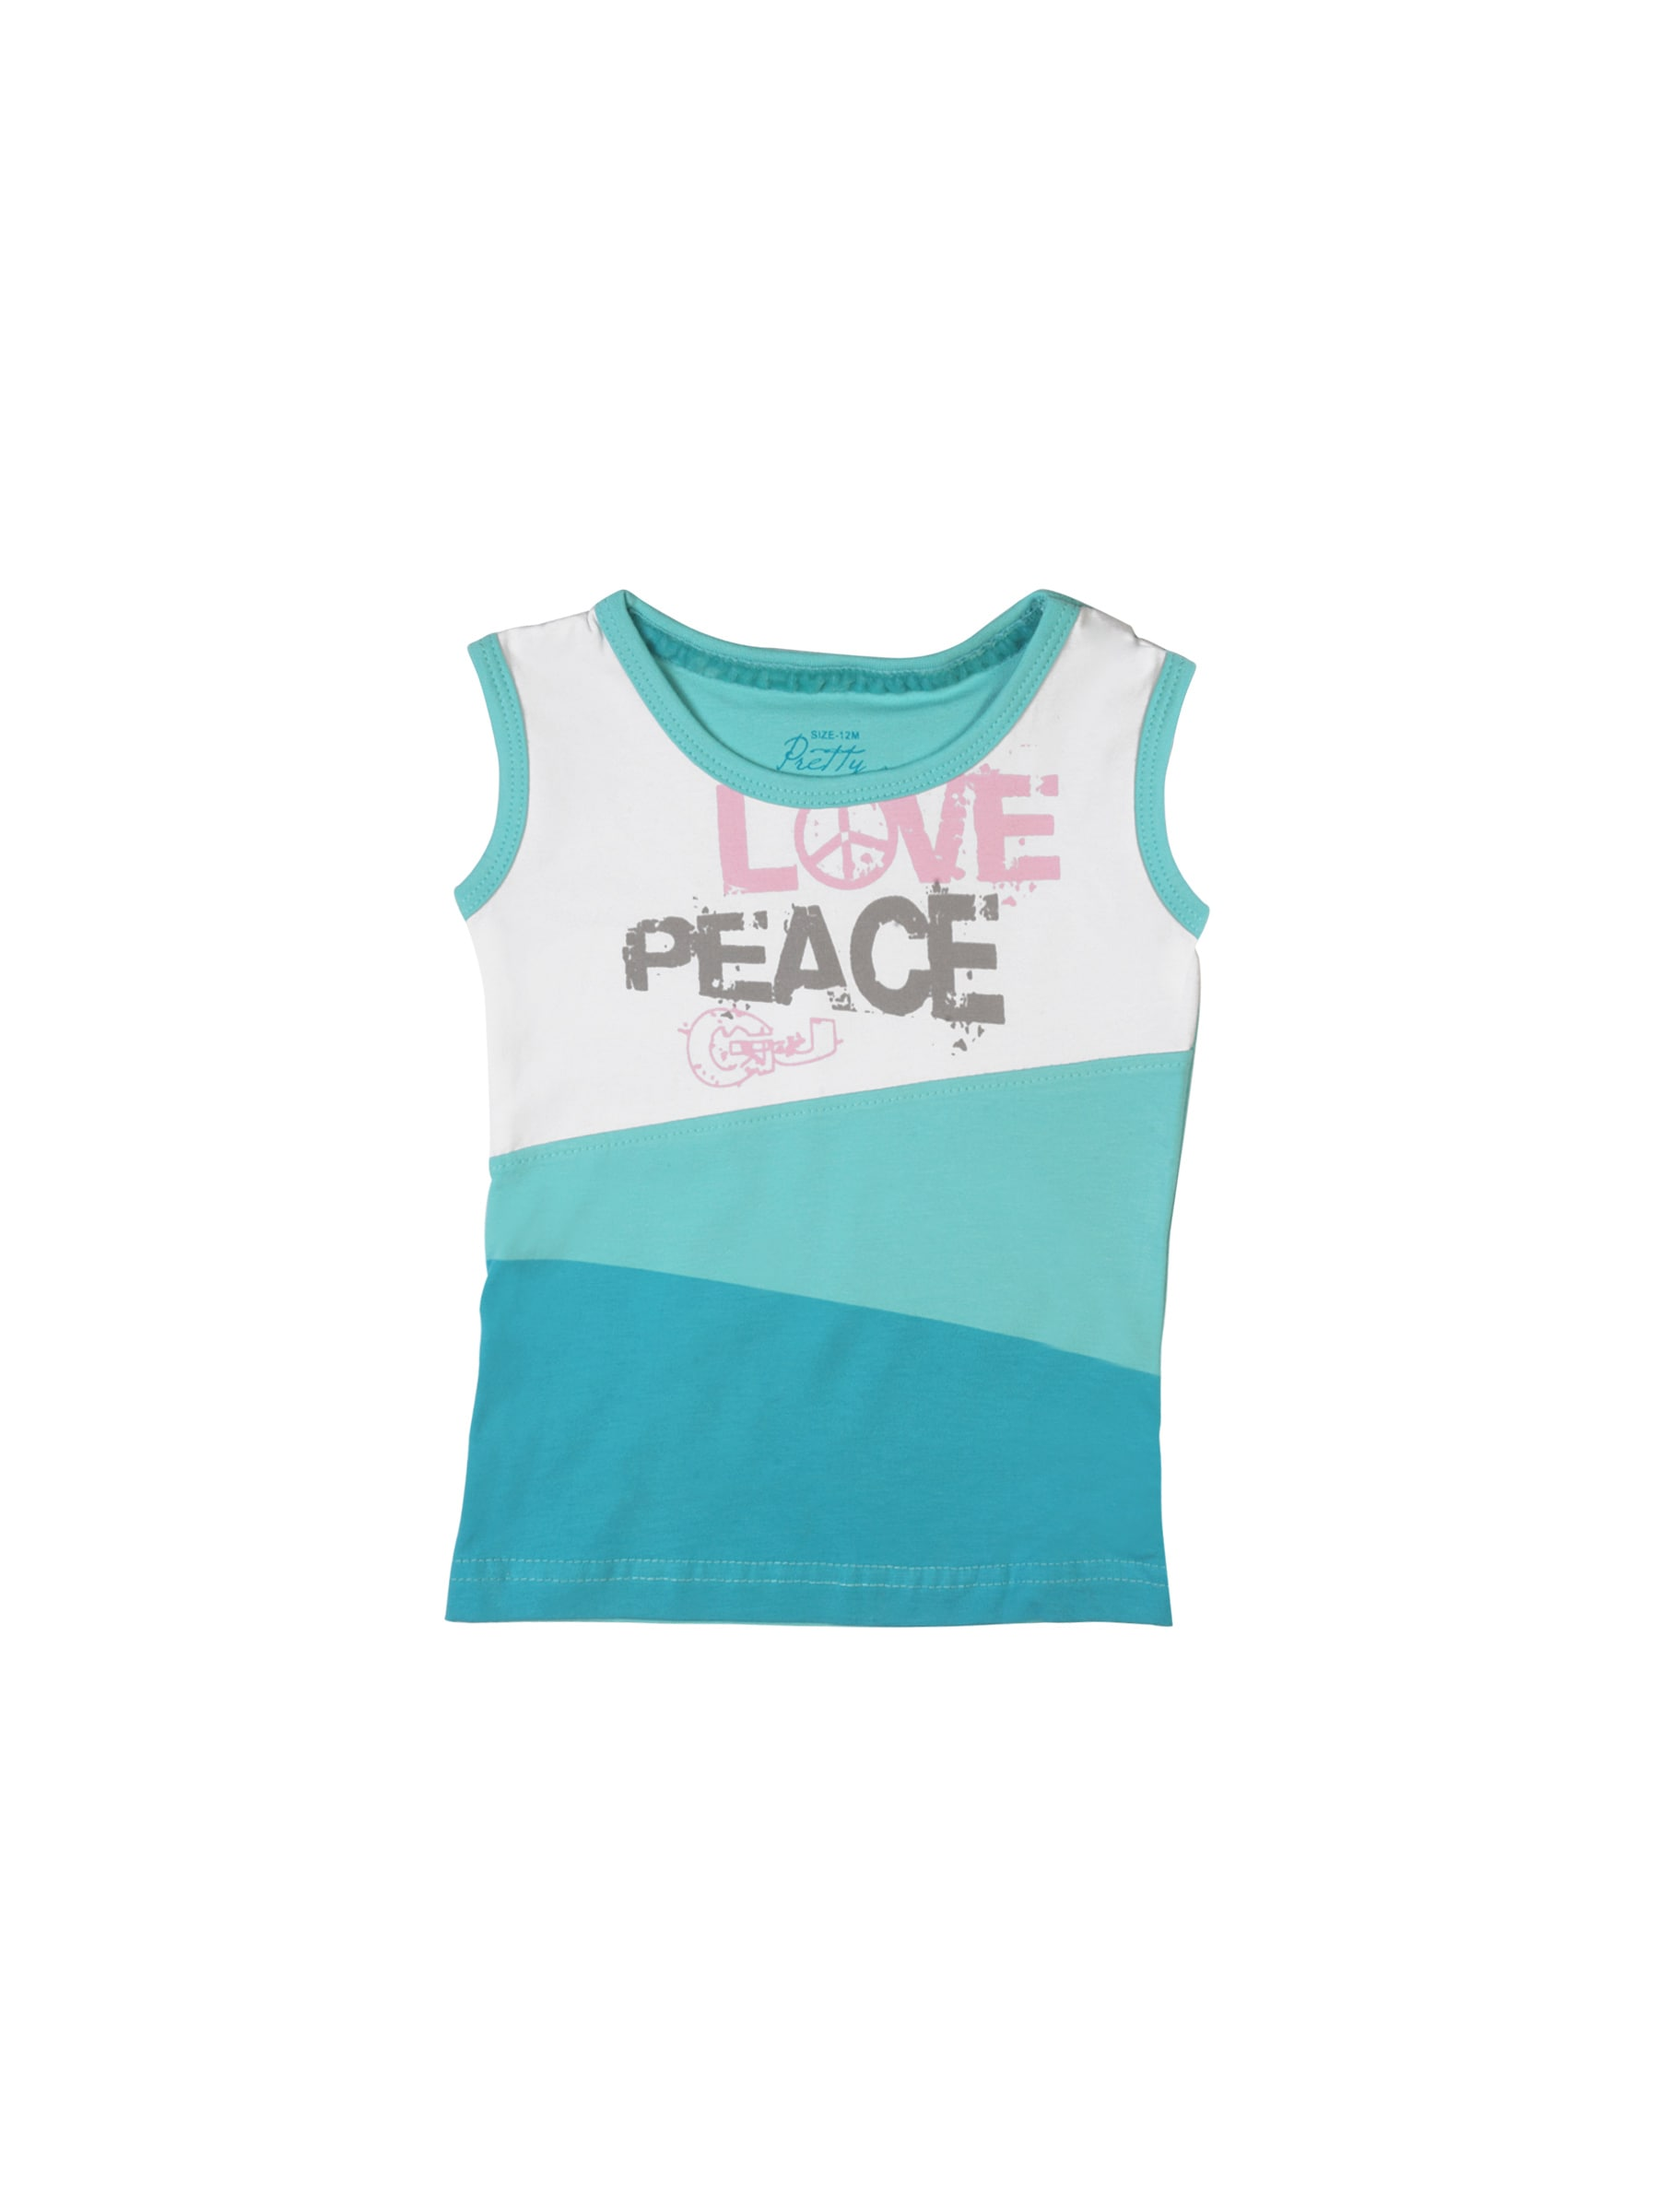

Product Title:  Gini and Jony Girls Pretty Blossom Blue Top

 ==================== Recommended products ====================


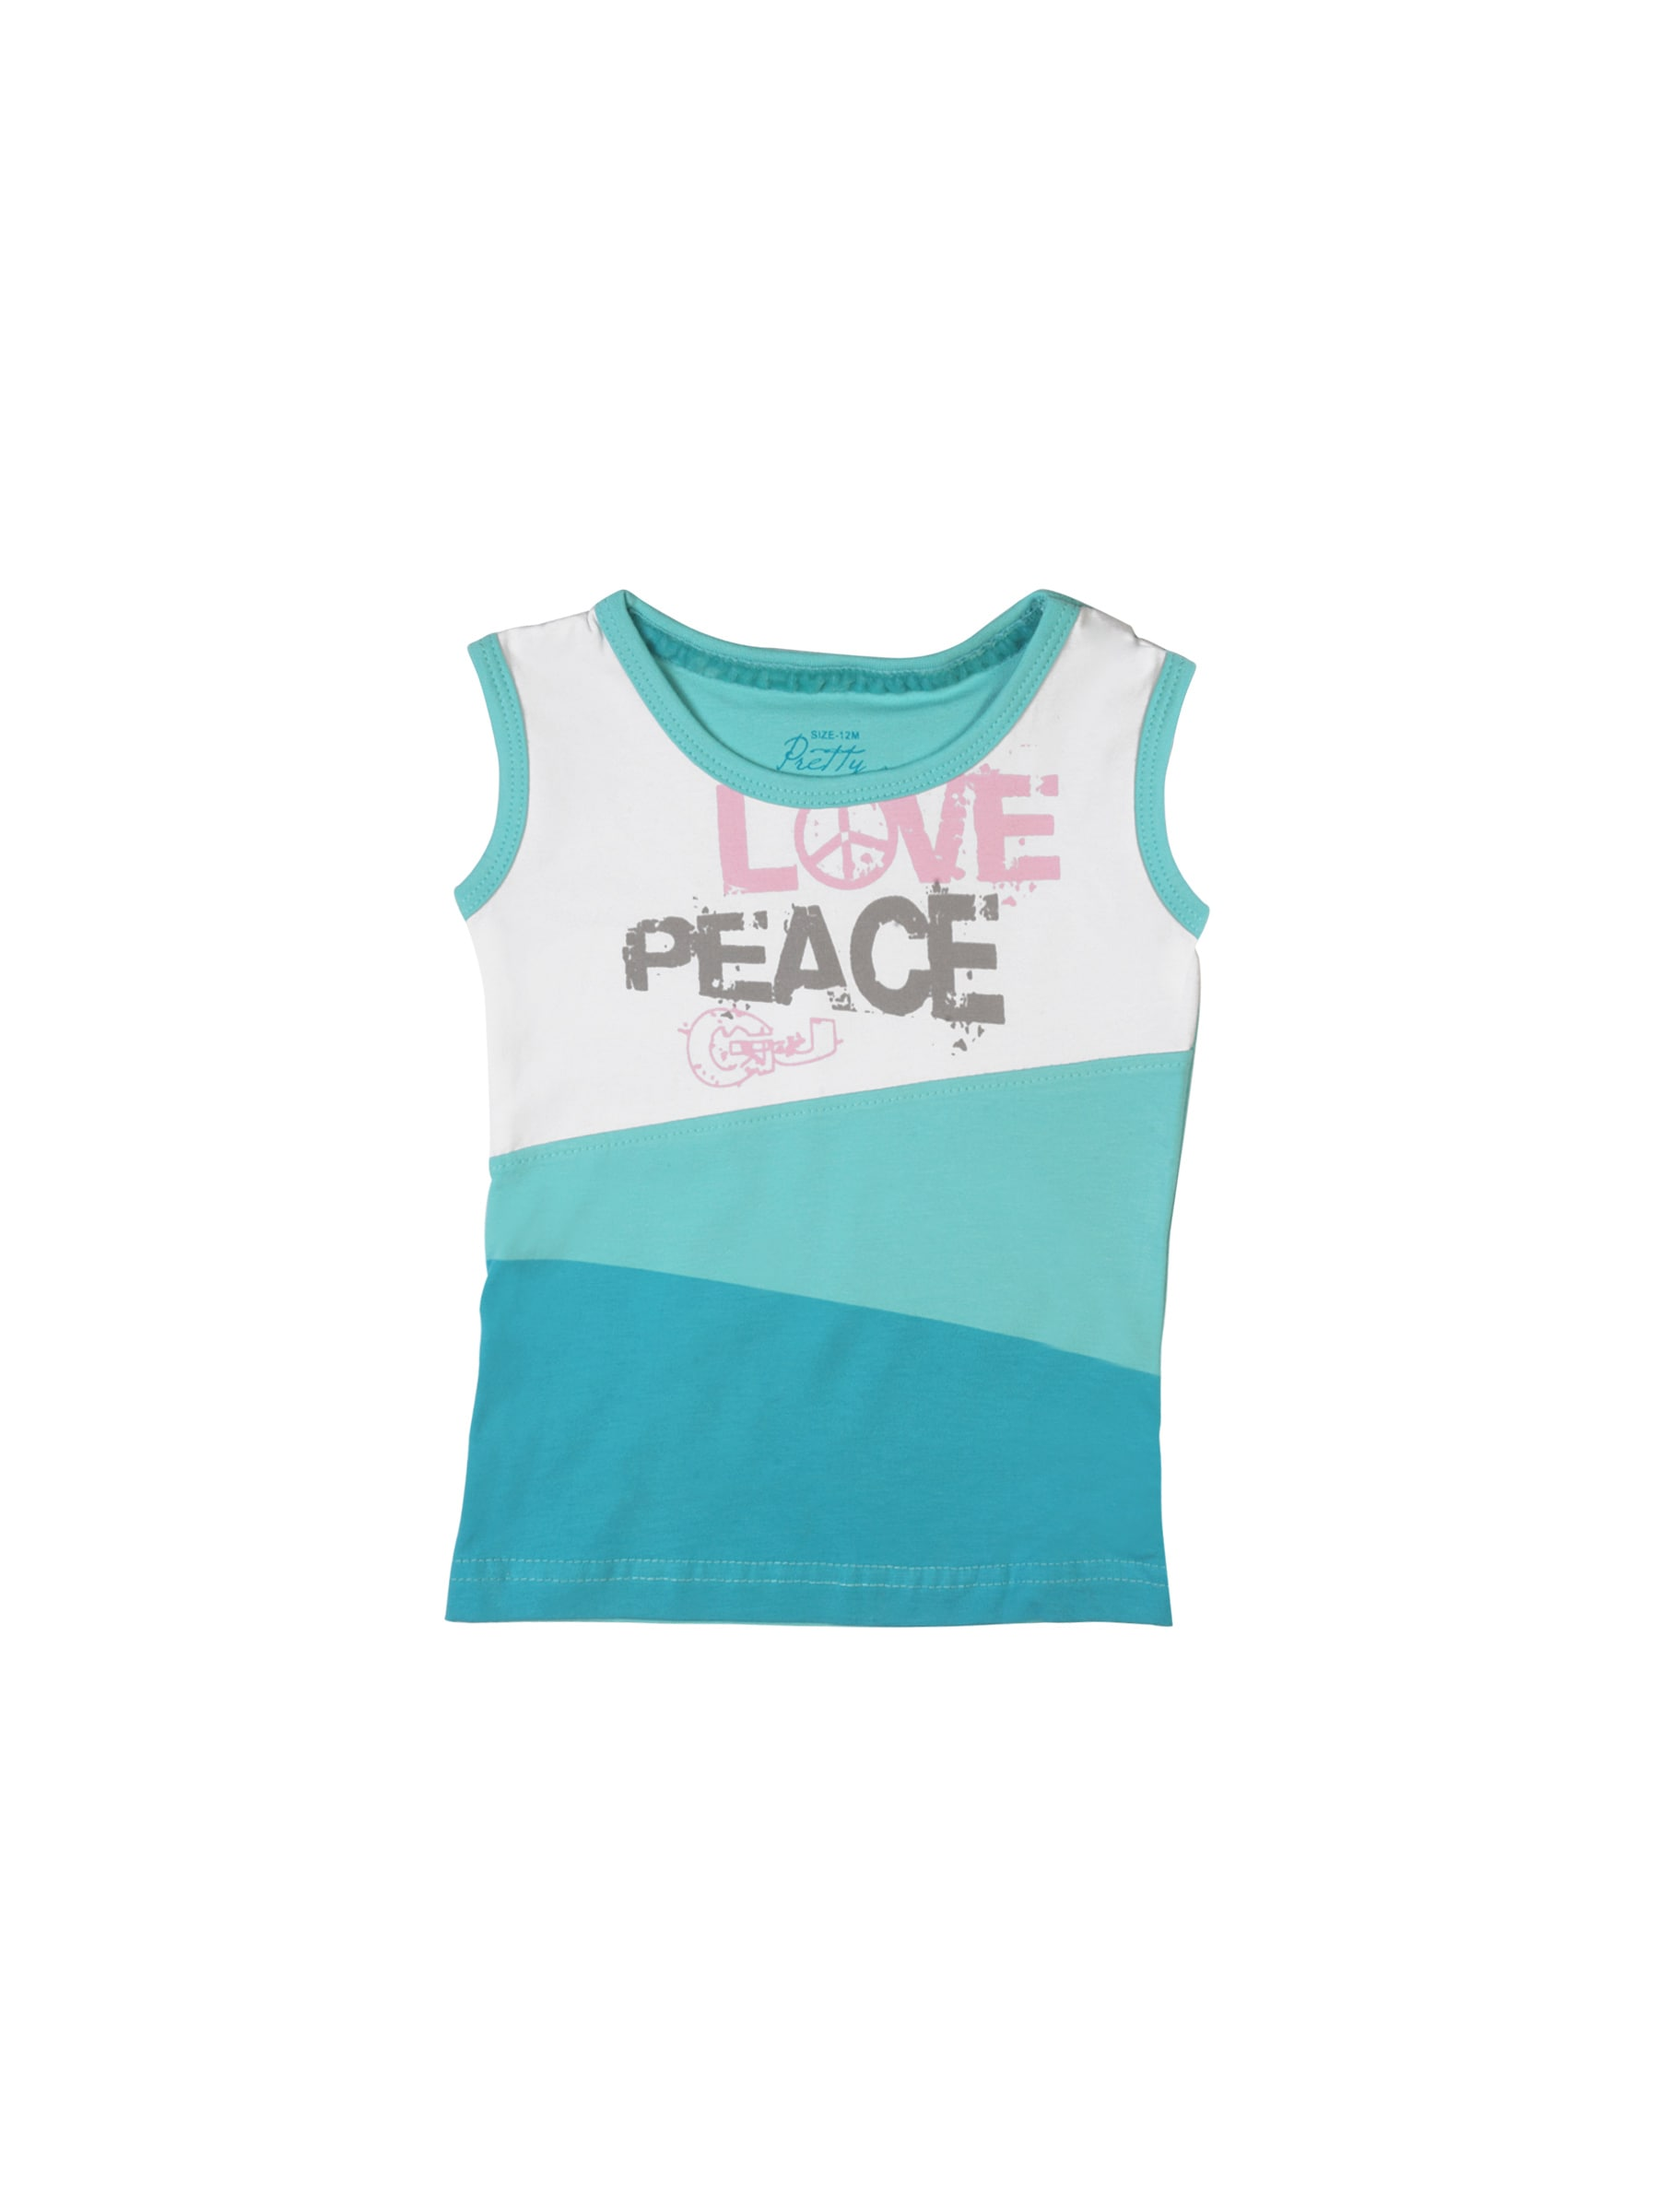

Product Title:  Gini and Jony Girls Pretty Blossom Blue Top
Euclidean Distance from input image: 6.6072494e-06


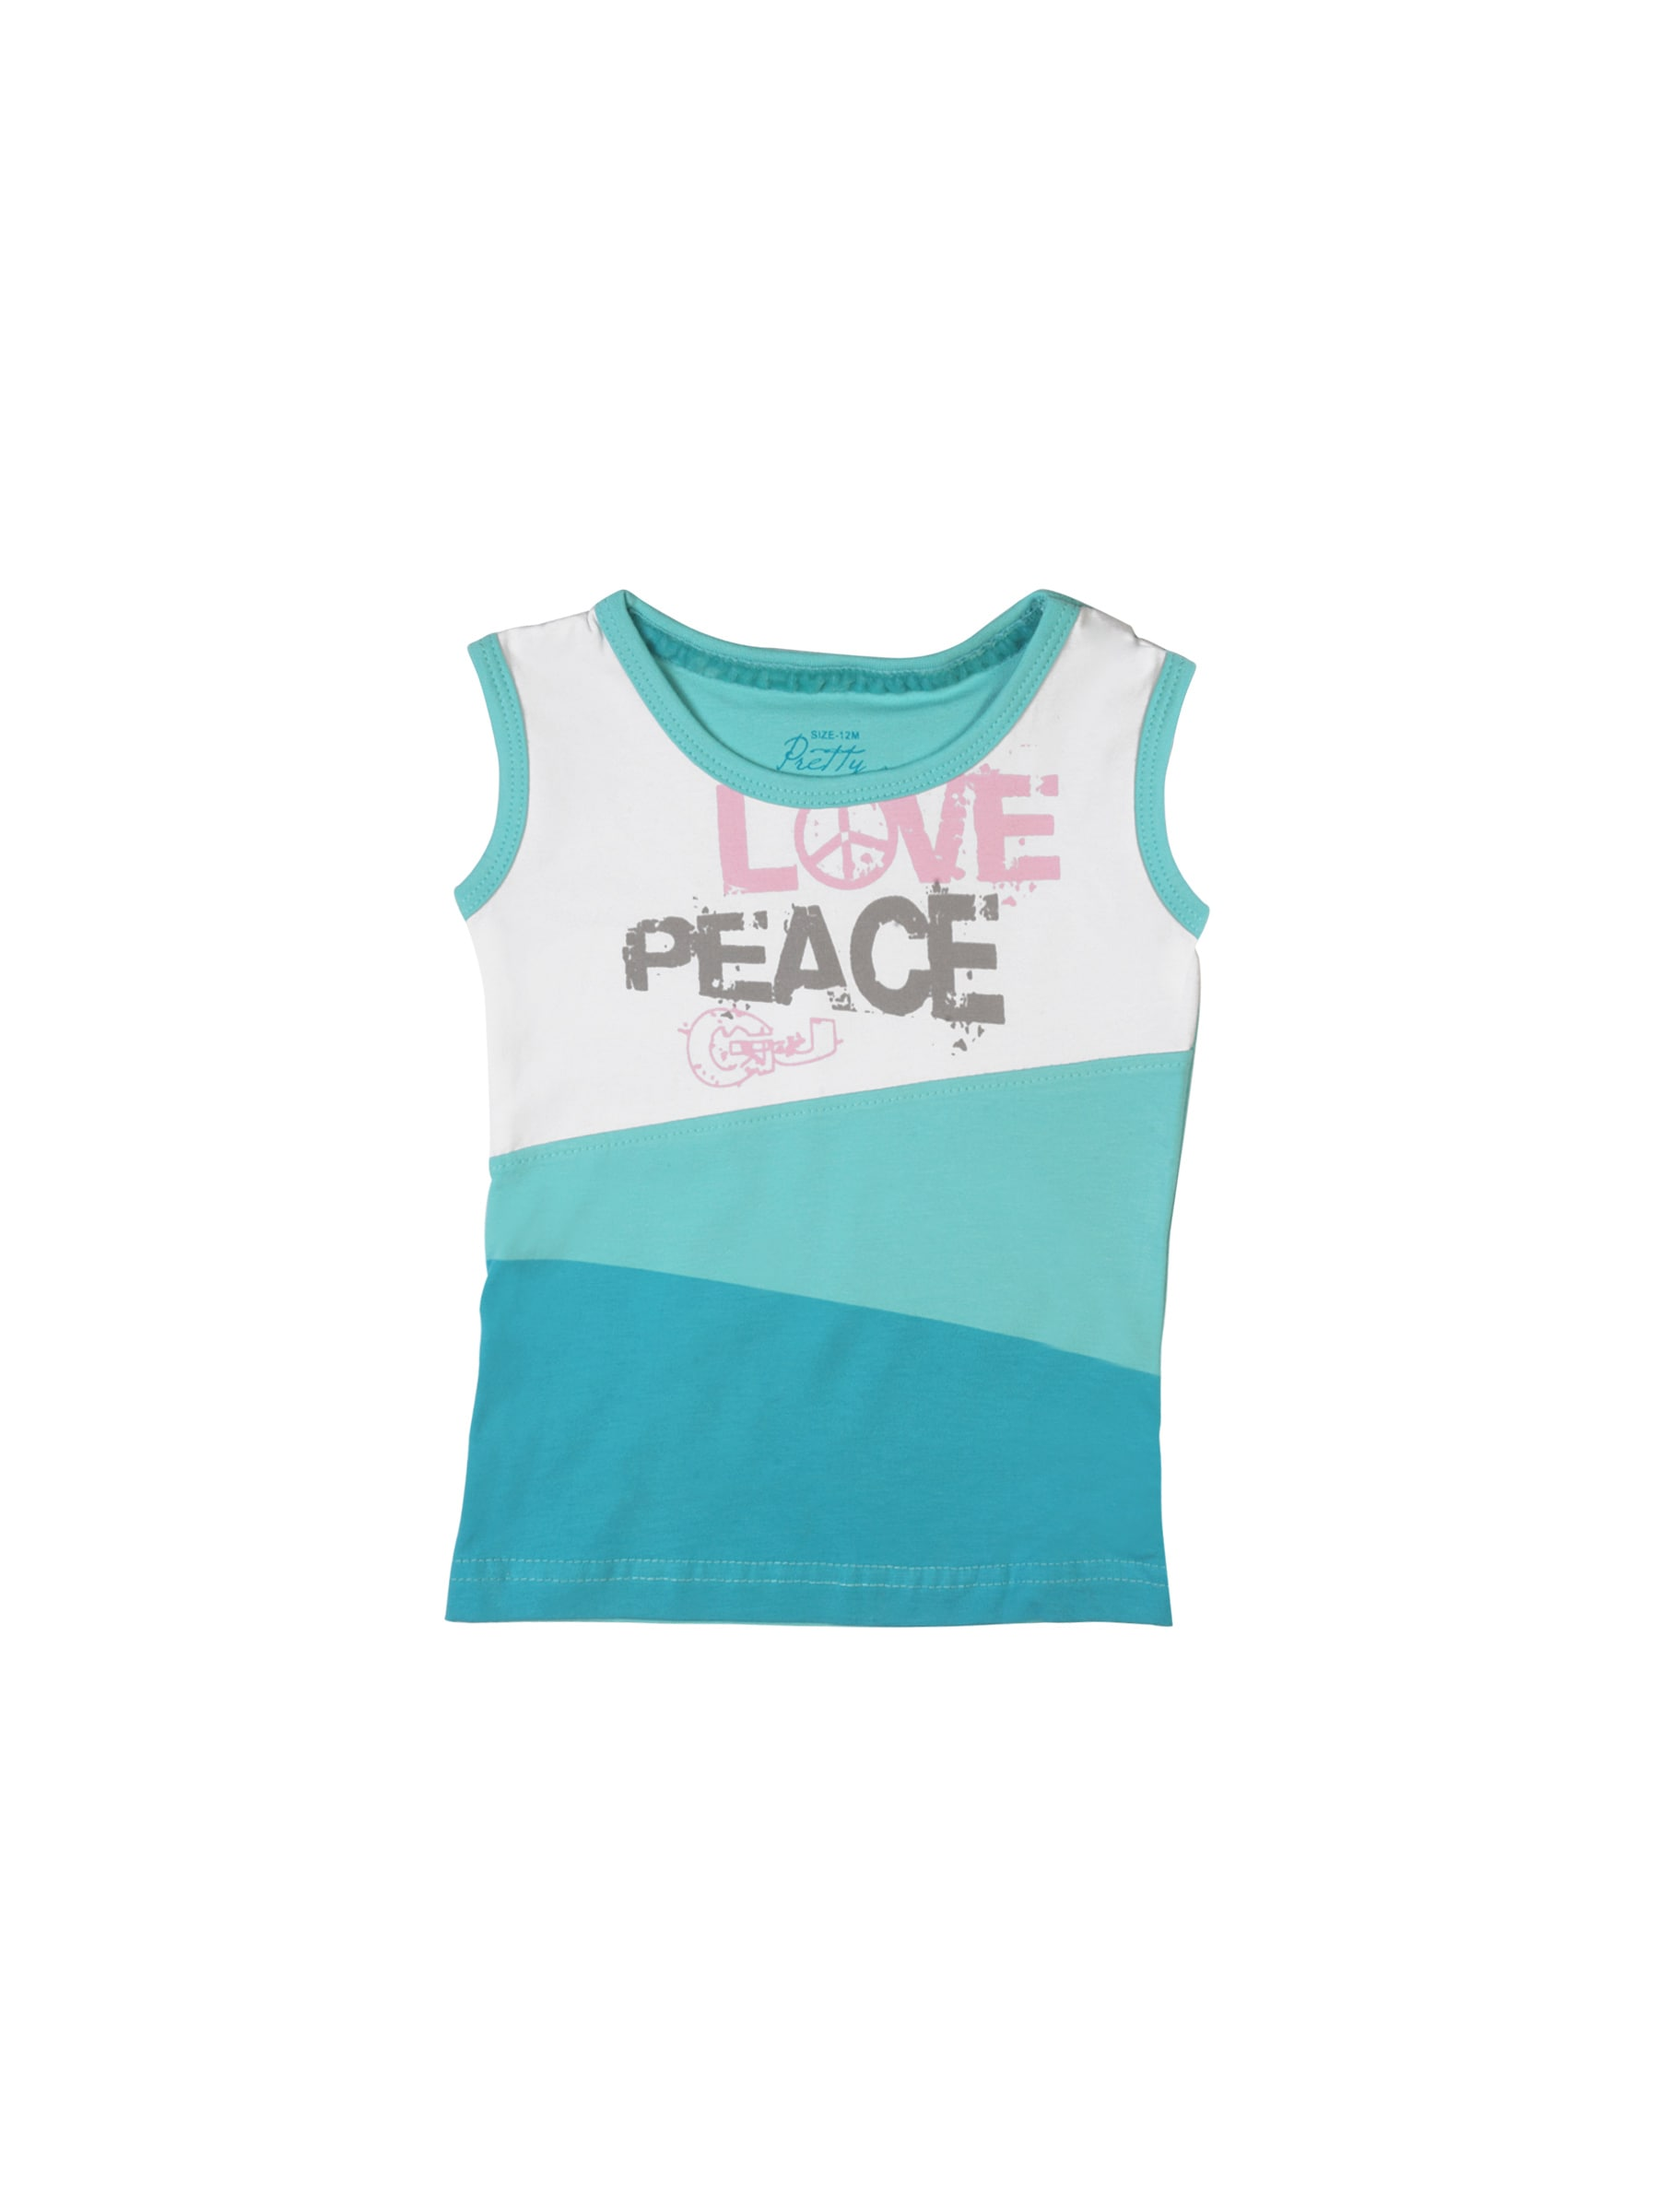

Product Title:  Gini and Jony Girls Pretty Blossom Blue Top
Euclidean Distance from input image: 6.6072494e-06


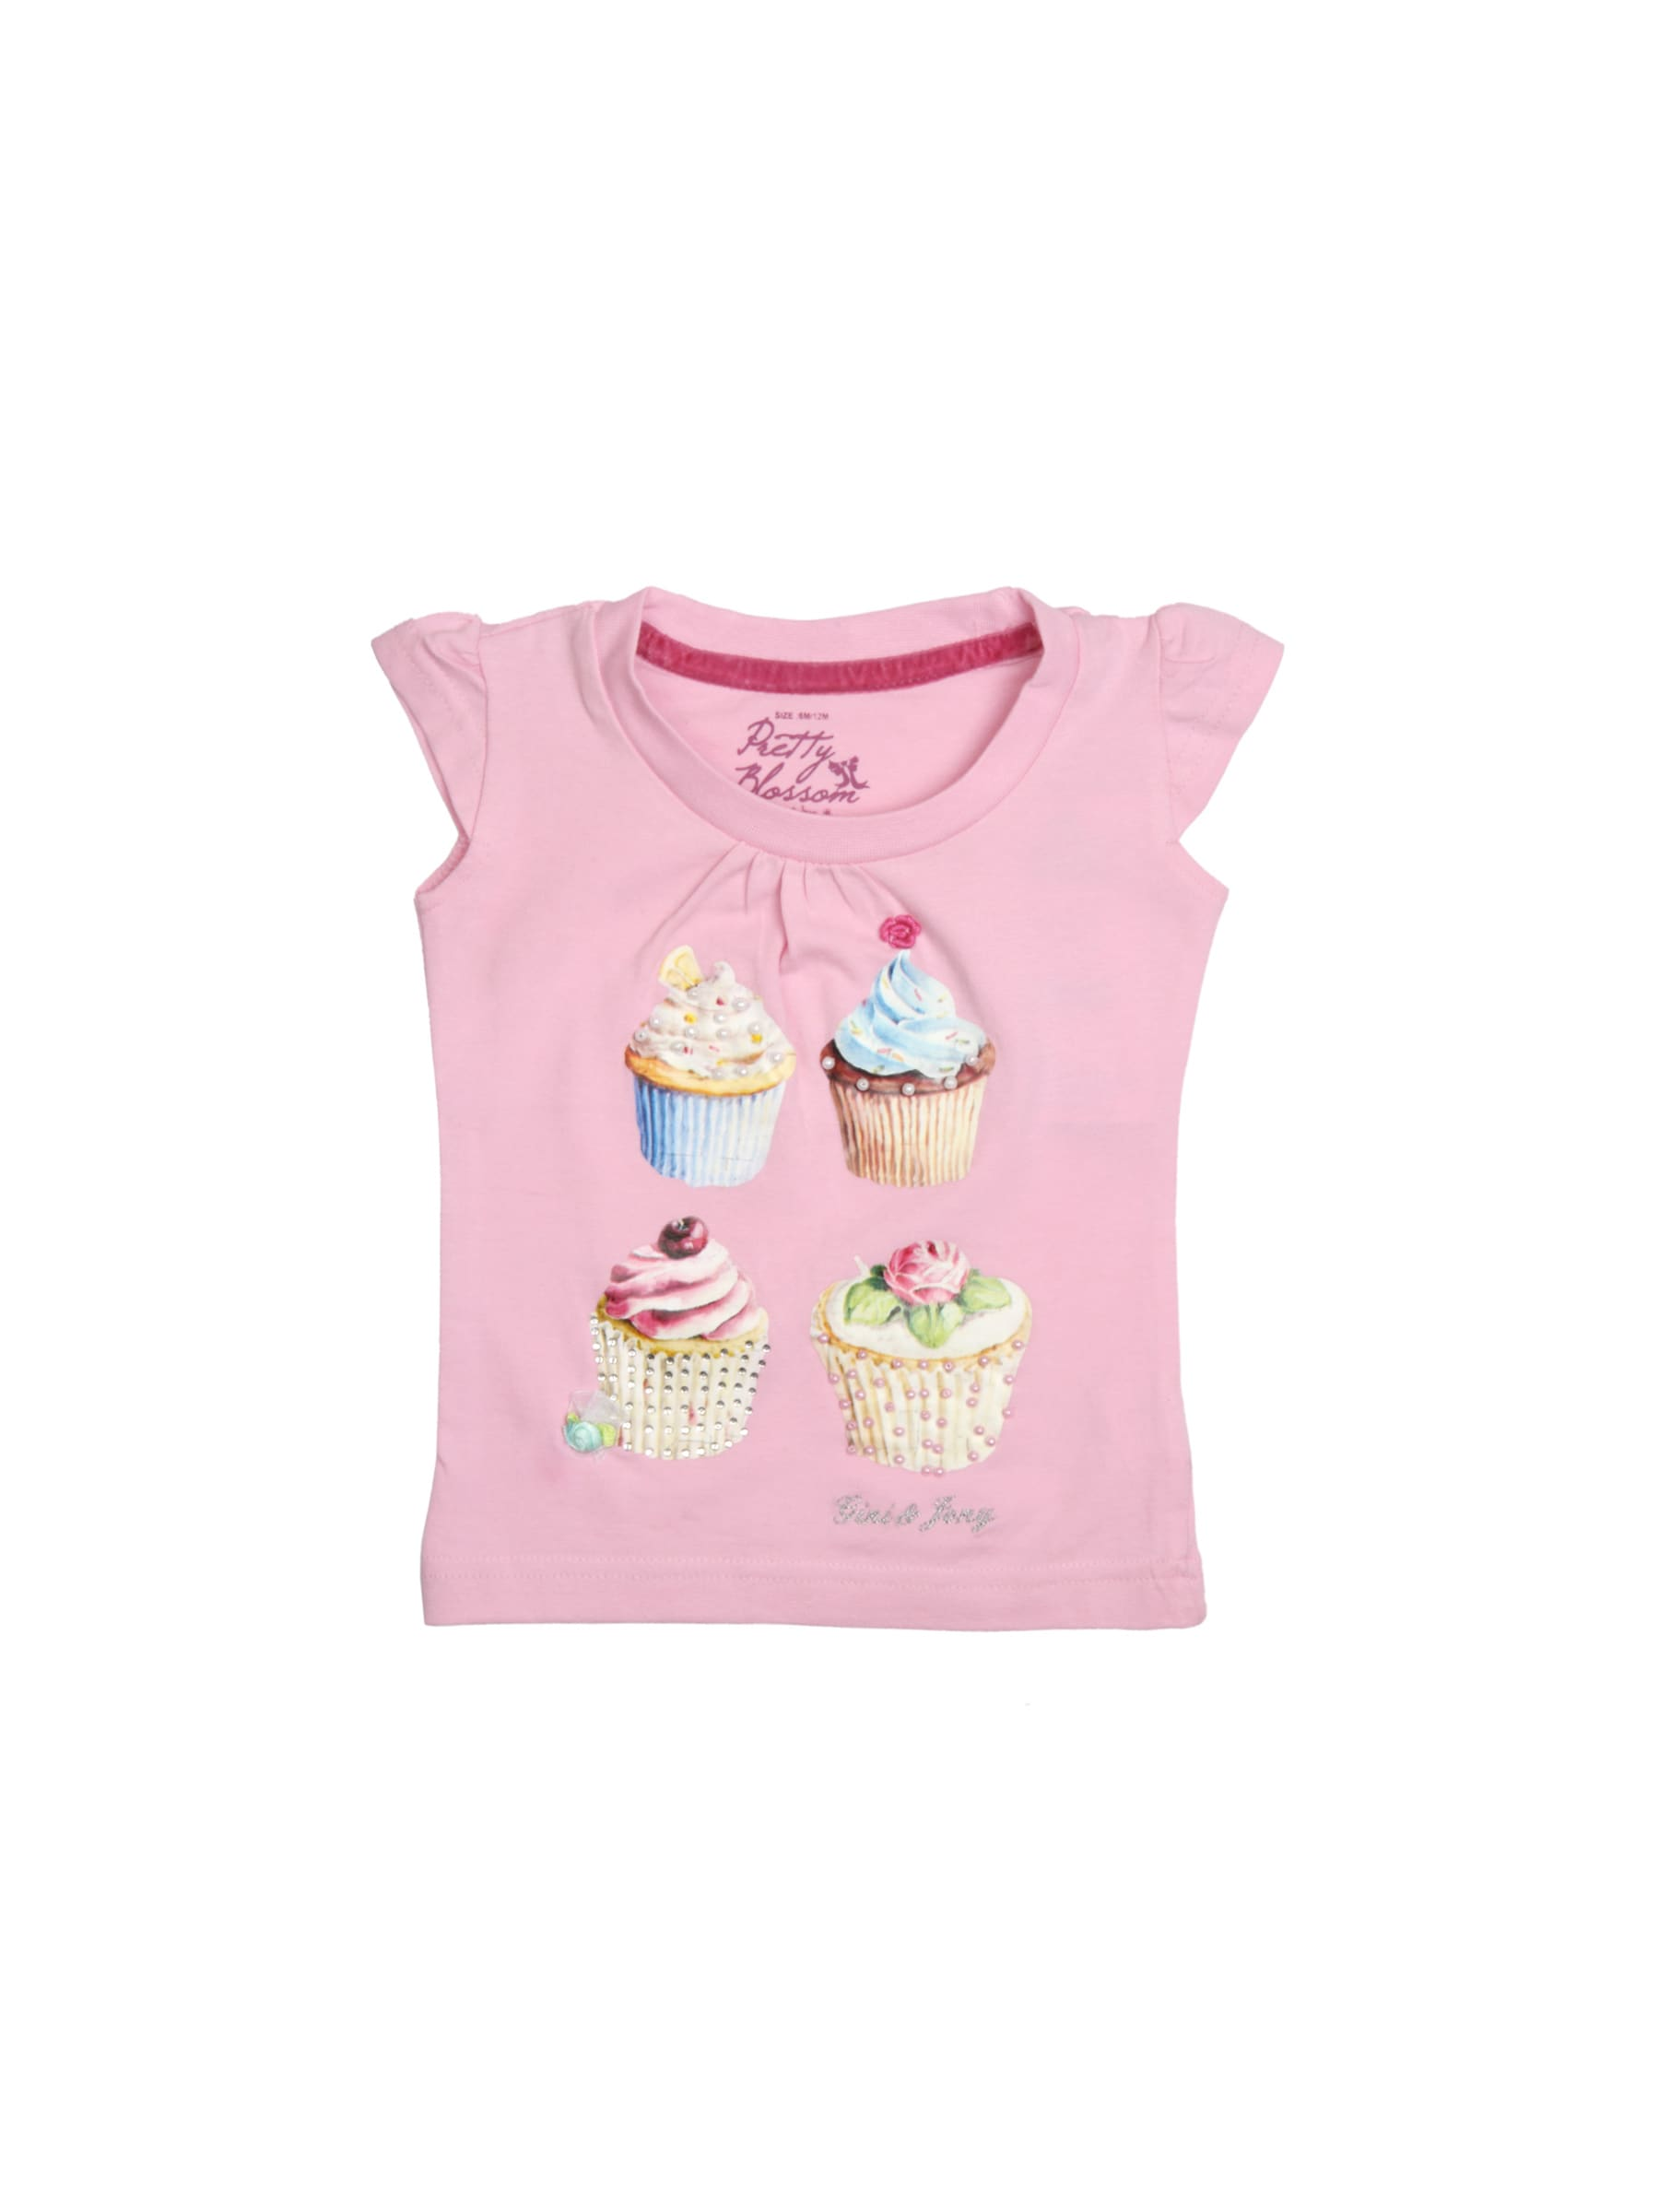

Product Title:  Gini and Jony Girls Pretty Pink Top
Euclidean Distance from input image: 9.735081


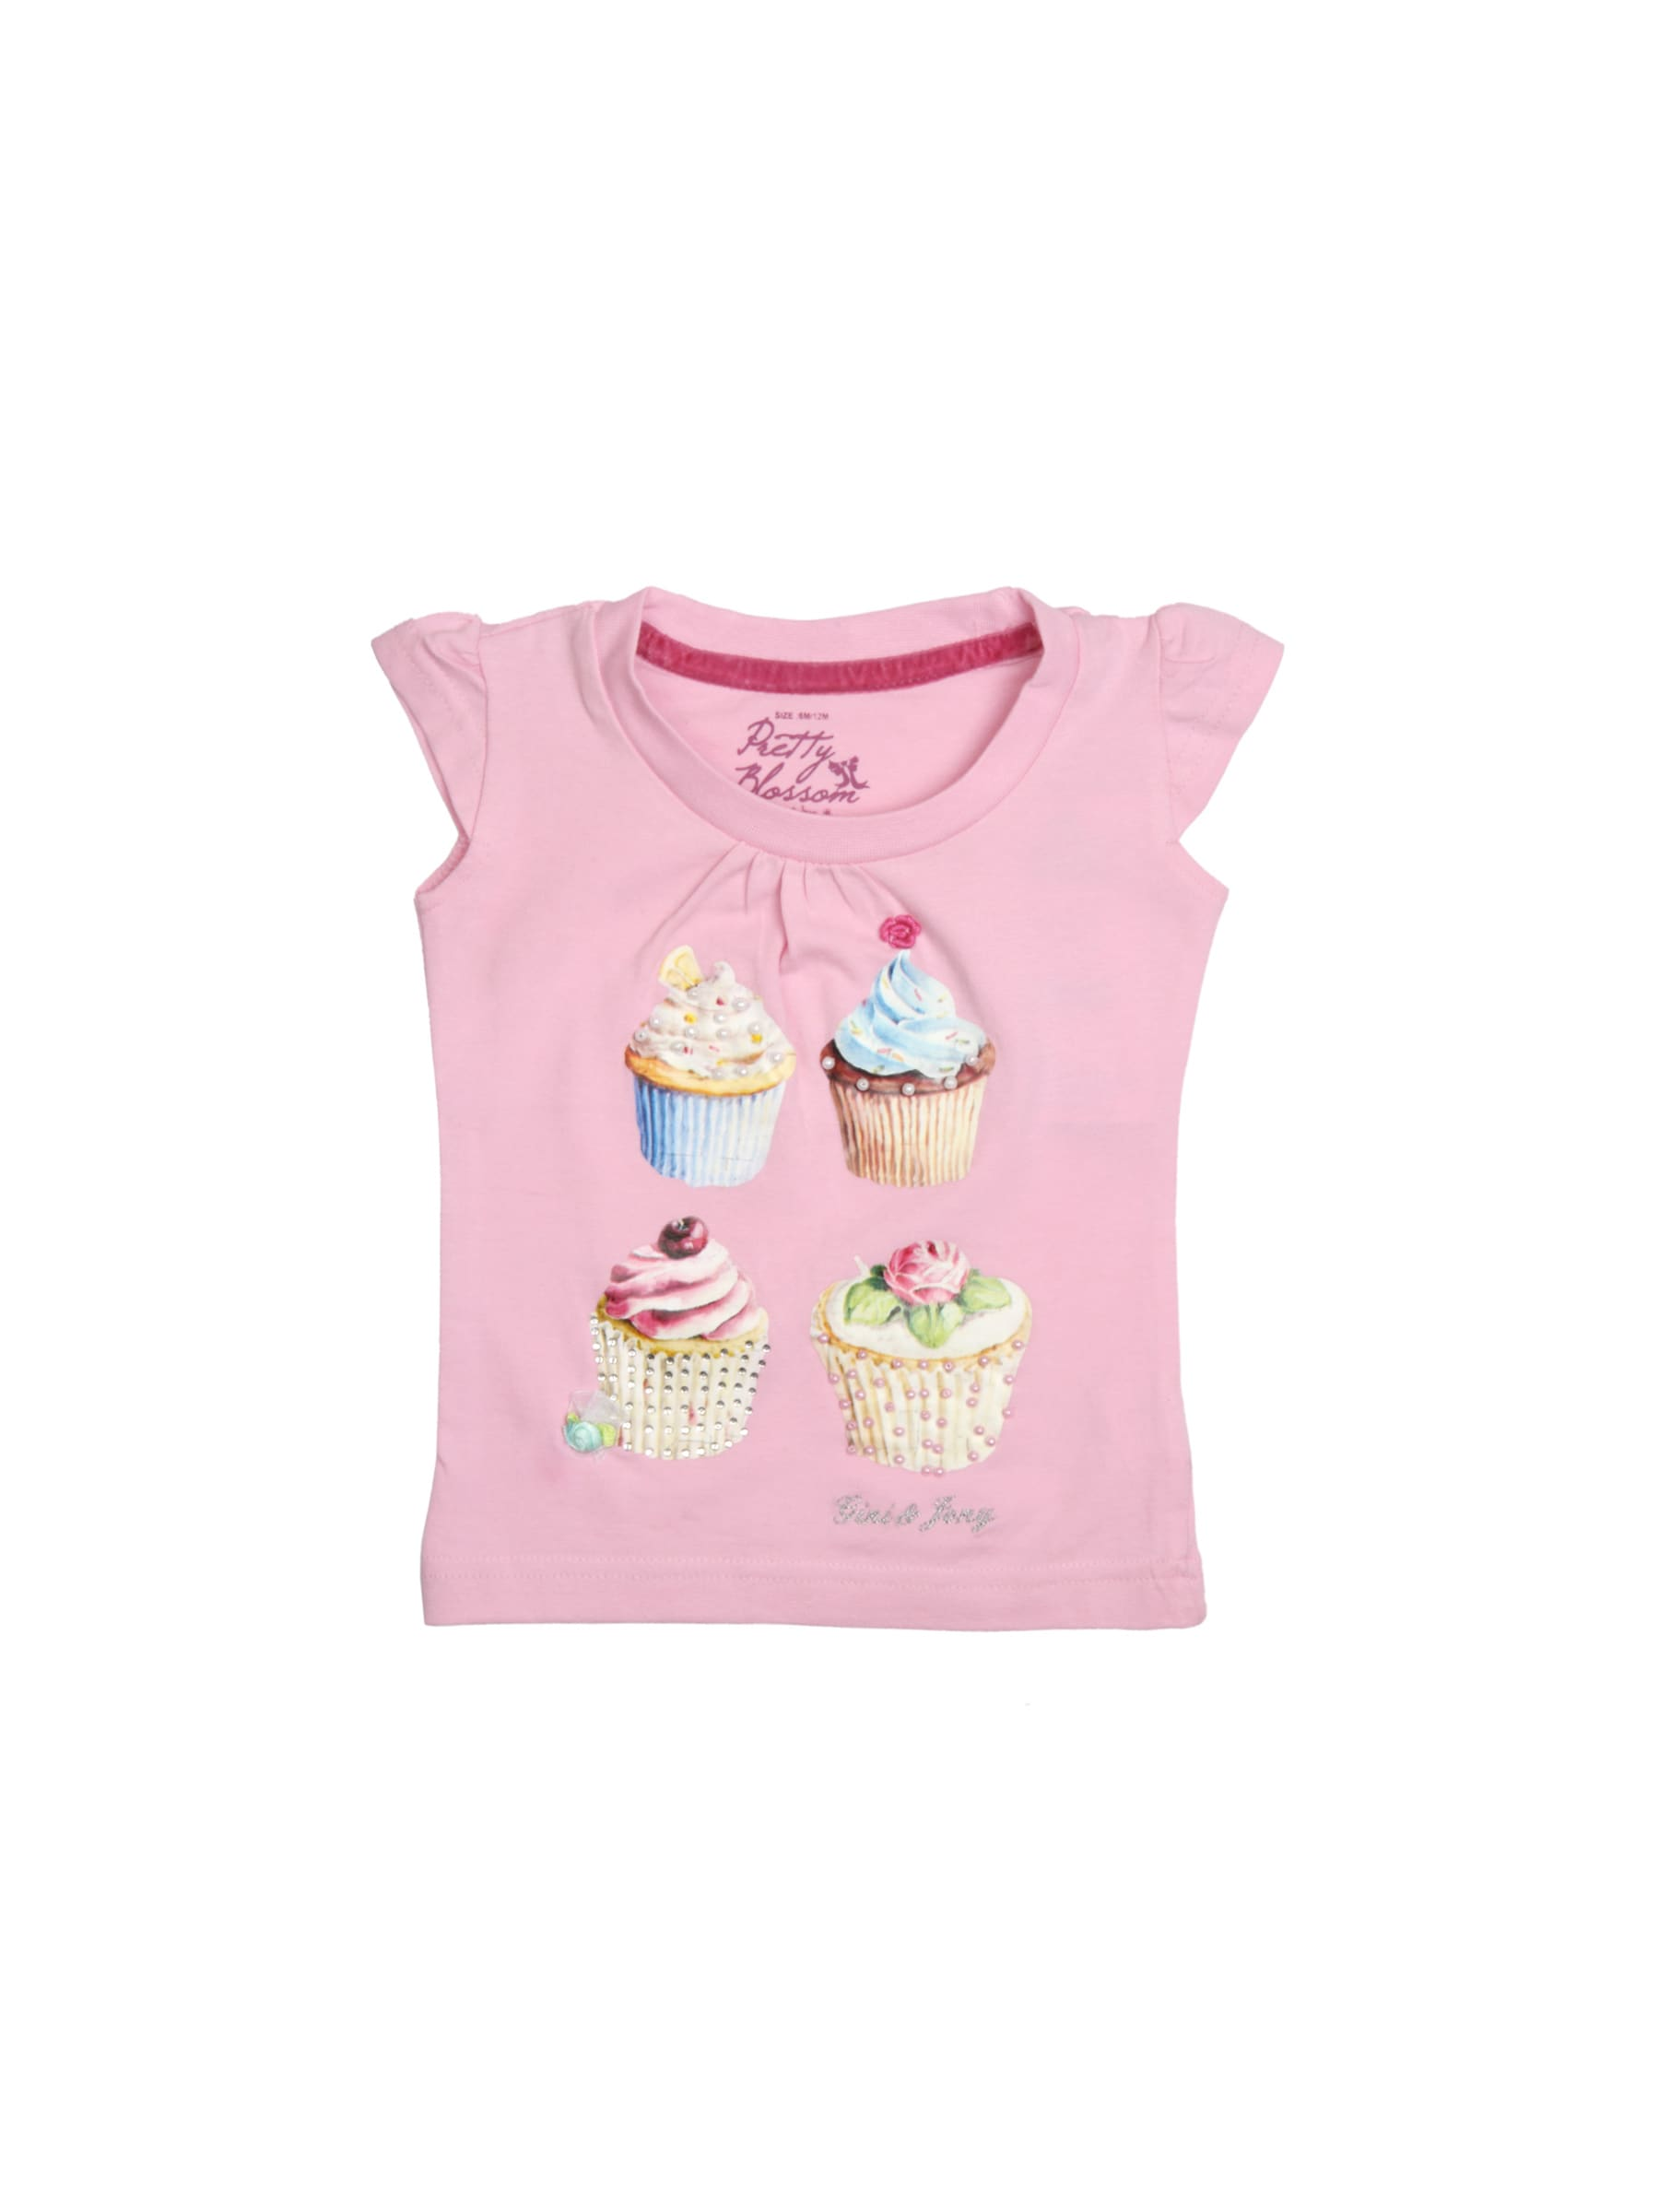

Product Title:  Gini and Jony Girls Pretty Pink Top
Euclidean Distance from input image: 9.735081


In [19]:
get_similar_products_cnn('40143', 5)